In [1]:
import pylab
import numpy as np
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.tools.visualization import plot_histogram
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit import Parameter
from qiskit.circuit.library.phase_oracle import PhaseOracle

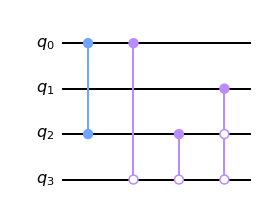

In [2]:
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError

input_sat_instance = '''
p cnf 4 1
1 2 3 0
-1 -2 3 4 0
3 -4 0
1 -4 0
'''

fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(input_sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except MissingOptionalLibraryError as ex:
    print(ex)
finally:
    os.remove(file_name)

oracle.draw('mpl')

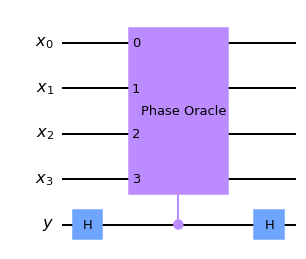

In [3]:
n = 4

x = QuantumRegister(n,'x')
y = QuantumRegister(1,'y')
oracle2 = QuantumCircuit(x, y, name="Oracle")
oracle2.h(y)
oracle2.append(oracle.to_gate().control(), [y]+list(x))
oracle2.h(y)

oracle2.draw('mpl')

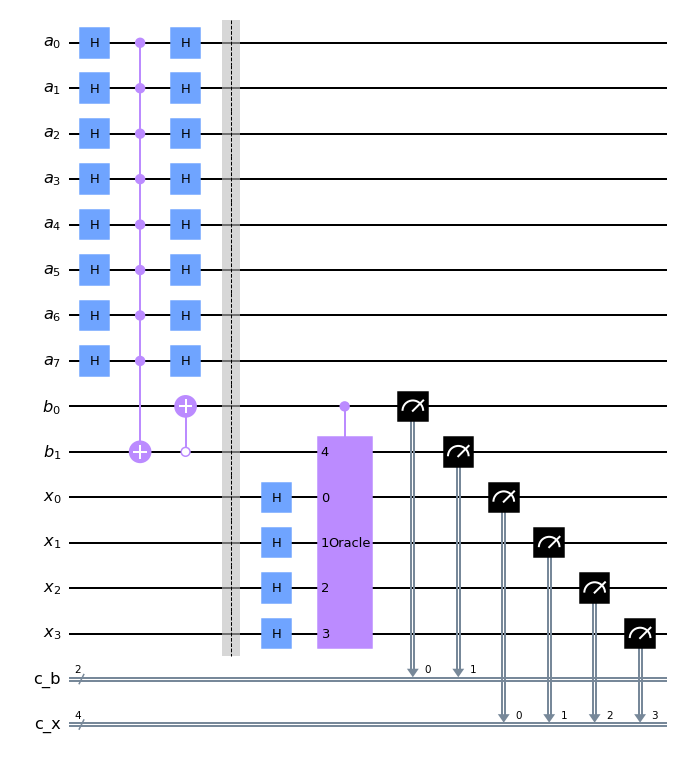

In [4]:
a = QuantumRegister(2 * n, 'a')
b = QuantumRegister(2, 'b')
x = QuantumRegister(n, 'x')
c_b = ClassicalRegister(2, 'c_b')
c_x = ClassicalRegister(n, 'c_x')
ge = QuantumCircuit(a, b, x, c_b, c_x)
for i in range(2 * n):
    ge.h(a[i])
ge.mcx(list(a), b[1])
for i in range(2 * n):
    ge.h(a[i])
ge.cx(b[1], b[0], ctrl_state=0)
# ge.measure(b, c_b)
ge.barrier()
for i in range(n):
    ge.h(x[i])
ge.append(oracle2.to_gate().control(), [b[0]] + list(x) + [b[1]])
ge.measure(b, c_b)
ge.measure(x, c_x)
ge.draw('mpl')

These two sections only used to draw circuit.

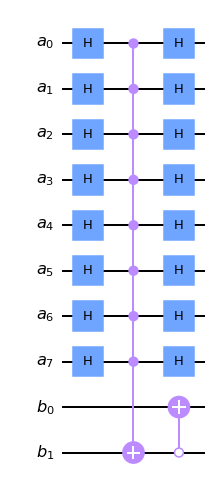

In [5]:
ge0 = QuantumCircuit(a, b)
for i in range(2 * n):
    ge0.h(a[i])
ge0.mcx(list(a), b[1])
for i in range(2 * n):
    ge0.h(a[i])
ge0.cx(b[1], b[0], ctrl_state=0)
ge0.draw('mpl')

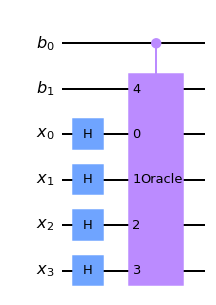

In [6]:
ge2 = QuantumCircuit(b, x)

for i in range(n):
    ge2.h(x[i])
ge2.append(oracle2.to_gate().control(), [b[0]] + list(x) + [b[1]])

ge2.draw('mpl')

In [7]:
from qiskit import Aer, transpile

backend_sim = Aer.get_backend('qasm_simulator')

job_sim = backend_sim.run(transpile(ge, backend_sim), shots=1000)

result_sim = job_sim.result()
counts = result_sim.get_counts()
print(counts)

{'0100 11': 65, '1101 11': 65, '0111 11': 52, '0001 11': 63, '0010 10': 1, '1111 11': 57, '1000 01': 53, '1010 10': 1, '0000 01': 61, '1010 01': 63, '1100 01': 80, '1110 01': 45, '0010 11': 65, '0101 11': 69, '1011 01': 71, '0110 11': 63, '0011 01': 62, '1001 01': 61, '0111 10': 1, '1110 10': 1, '0100 10': 1}


In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def binary(x, length):
    if x == 0:
        return '0' * length
    return binary(x//2, length-1) + str(x % 2)

[Text(0, 0, '00'), Text(1, 0, '01'), Text(2, 0, '10'), Text(3, 0, '11')]

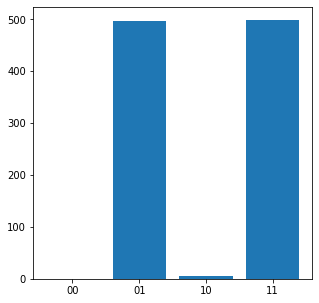

In [10]:

# x, y: position
x = list(range(4))
x_tickets = [binary(_x, 2) for _x in x]

zz = np.zeros([len(x)])
for _i, i in enumerate(x):
    for j in range(2 ** n):
        k = binary(j, n) + ' ' + binary(i, 2)
        zz[_i] += counts[k] if k in counts.keys() else 0

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.bar(x, zz)
ax.set_xticks(x)
ax.set_xticklabels(x_tickets)


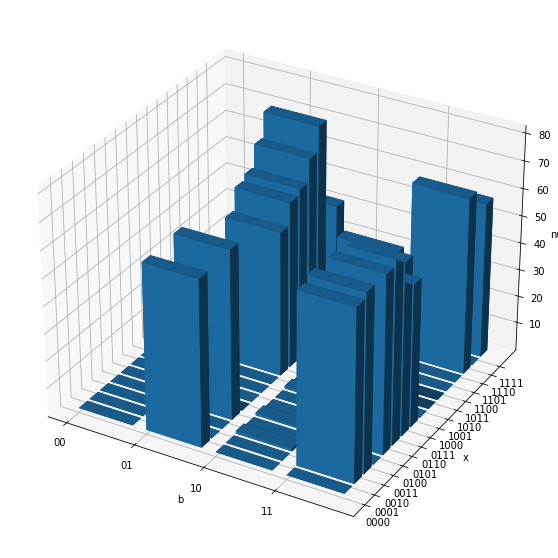

In [11]:
# x, y: position
x = list(range(4))
y = list(range(2 ** n))
x_tickets = [binary(_x, 2) for _x in x]
y_tickets = [binary(_y, n) for _y in y]

yy, xx = np.meshgrid(y, x)
zz = np.zeros([len(x), len(y)])
for i in x:
    for j in y:
        k = binary(j, n) + ' ' + binary(i, 2)
        zz[i][j] = counts[k] if k in counts.keys() else 0

xx_flat, yy_flat = xx.ravel(), yy.ravel()
z_flat = zz.ravel()

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("b")
ax.set_ylabel("x")
ax.set_zlabel("num")
ax.set_xticks(x)
ax.set_xticklabels(x_tickets)
ax.set_yticks(y)
ax.set_yticklabels(y_tickets)
ax.bar3d(xx_flat, yy_flat, 1, 0.8, 0.8, z_flat, shade=True)




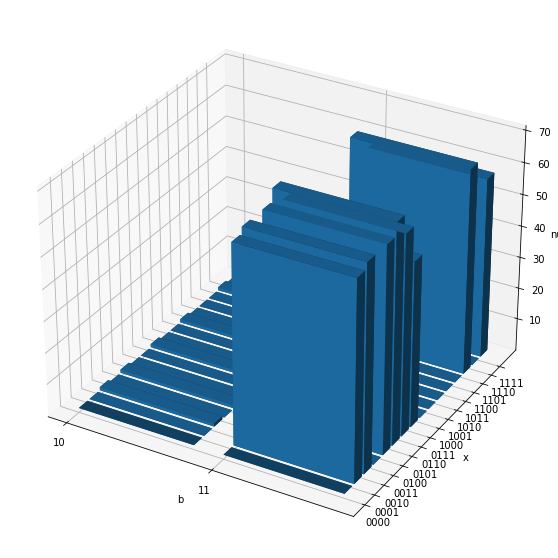

In [12]:
# x, y: position
x = [2,3]
y = list(range(2 ** n))
x_tickets = [binary(_x, 2) for _x in x]
y_tickets = [binary(_y, n) for _y in y]

yy, xx = np.meshgrid(y, x)
zz = np.zeros([len(x), len(y)])
for _i, i in enumerate(x):
    for _j, j in enumerate(y):
        k = binary(j, n) + ' ' + binary(i, 2)
        zz[_i][_j] = counts[k] if k in counts.keys() else 0

xx_flat, yy_flat = xx.ravel(), yy.ravel()
z_flat = zz.ravel()

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("b")
ax.set_ylabel("x")
ax.set_zlabel("num")
ax.set_xticks(x)
ax.set_xticklabels(x_tickets)
ax.set_yticks(y)
ax.set_yticklabels(y_tickets)
ax.bar3d(xx_flat, yy_flat, 1, 0.8, 0.8, z_flat, shade=True)


